# This notebook examines general trends in FAC data
A more thorough writeup can be found in https://drive.google.com/open?id=1U6stzP7qhqB3B10kNYnWdlgtAibwoFEI6cuKOSSq-ZU

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

processed_path = '/data/ihwang/data_journalism/allfac/processed/'
df_general = pd.read_pickle(processed_path + 'general.pkl')
# print('General DF\n', df_general.head())

# Agency prefix dictionary:
with open(processed_path + 'agency_dict', 'rb') as f_w:
    agency_dict = pickle.load(f_w)
# Entity code dictionary:
with open(processed_path + 'entity_dict', 'rb') as f_w:
    entity_dict = pickle.load(f_w)

## Plot percent of all audits by entity type

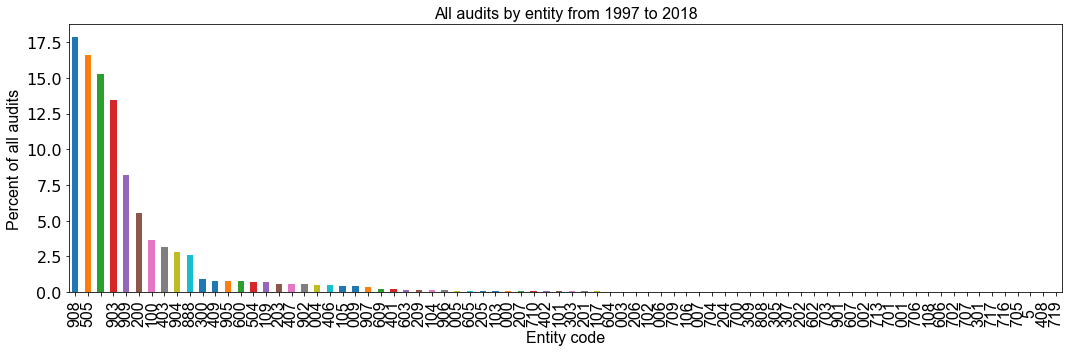

Total number of audits: 838217


In [223]:
fig, axes = plt.subplots(figsize=(15, 5))
entity_groups = df_general.groupby('TYPEOFENTITY').size().sort_values(ascending=False) / len(df_general) * 100
percent_audits_plot = entity_groups.plot(kind='bar', fontsize=16)
percent_audits_plot.set_xlabel('Entity code', fontsize=16, fontname='Arial')
percent_audits_plot.set_xticklabels(labels=entity_groups.index, fontsize=16, fontname='Arial')
percent_audits_plot.set_ylabel('Percent of all audits', fontsize=16, fontname='Arial')
percent_audits_plot.set_title(
    'All audits by entity from %s to %s' %(min(df_general['AUDITYEAR']), max(df_general['AUDITYEAR'])),
    fontsize=16, fontname='Arial'
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(df_general))

## Plot percent of all audits by state

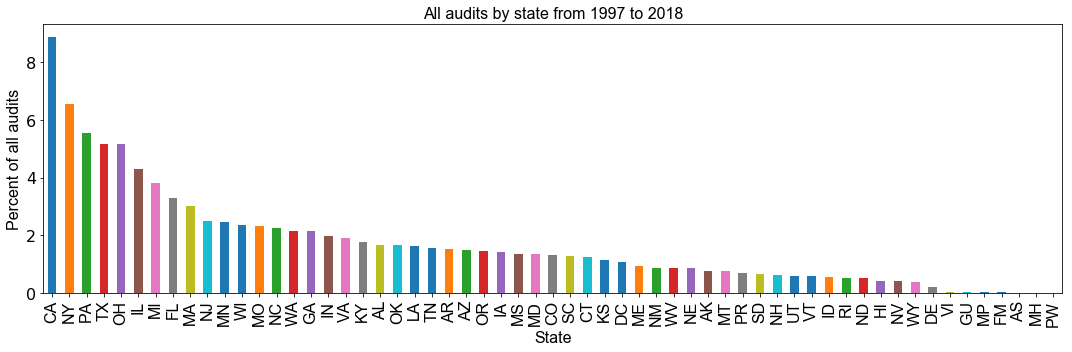

Total number of audits: 838217


In [224]:
fig, axes = plt.subplots(figsize=(15, 5))
entity_groups = df_general.groupby('STATE').size().sort_values(ascending=False) / len(df_general) * 100
percent_audits_plot = entity_groups.plot(kind='bar', fontsize=16)
percent_audits_plot.set_xlabel('State', fontsize=16, fontname='Arial')
percent_audits_plot.set_xticklabels(labels=entity_groups.index, fontsize=16, fontname='Arial')
percent_audits_plot.set_ylabel('Percent of all audits', fontsize=16, fontname='Arial')
percent_audits_plot.set_title(
    'All audits by state from %s to %s' %(min(df_general['AUDITYEAR']), max(df_general['AUDITYEAR'])),
    fontsize=16, fontname='Arial'
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(df_general))

## Findings for selected fields
Can select particular year, or set year = None in order to get aggregate statistics. Each plot is sorted by the criterion selected in top_criterion (either 'total' (number of audits) or 'bad_findings').
* Financial Statements (TYPEREPORT_FS) and Major Program Compliance (TYPEREPORT_MP): opinion = U, Q, A or D, but focus on Q, A and D since the U's are majority and the other fields are super minorities
* Questioned Costs (QCOSTS), Reportable Condition (REPORTABLECONDITION, REPORTABLECONDITION_MP), Material Noncompliance (MATERIALNONCOMPLIANCE), and Material Weakness (MATERIALWEAKNESS, MATERIALWEAKNESS_MP): finding = primarily Y or N

In [201]:
# df_plot = df_general.copy(deep=True)
# df_plot = df_general[df_general['AUDITYEAR'] == 2018]
# df_plot = df_general[
#     df_general['STATE'].isin(df_general['STATE'].value_counts().sort_values(ascending=False).head(10).index)
# ]
# df_plot = df_general[
#     (df_general['STATE'].isin(df_general['STATE'].value_counts().sort_values(ascending=False).head(10).index)) &
#     (df_general['AUDITYEAR'] == 2016)
# ]
field = 'QCOSTS'
series_grouped = df_general.groupby('STATE')[field].value_counts()
df_grouped = series_grouped.unstack()
df_grouped_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)
top_field = df_grouped_normalized.sort_values('Y', ascending=False).head(10).index
df_plot = df_general[(df_general['STATE'].isin(top_field))]
# df_plot = df_general[
#     (df_general['STATE'].isin(top_field)) &
#     (df_general['AUDITYEAR'] == 2016)
# ]

In [202]:
fields = ['TYPEREPORT_FS', 'QCOSTS', 'MATERIALWEAKNESS', 'MATERIALNONCOMPLIANCE']
# fields = ['TYPEREPORT_MP', 'REPORTABLECONDITION_MP', 'MATERIALWEAKNESS_MP']
sortbys = ['TYPEOFENTITY', 'STATE', 'OVERSIGHTAGENCY']
print('Possible field types:')
for field in fields:
    print('%s: %s' %(field, ', '.join(set(df_general[field]))))

Possible field types:
TYPEREPORT_FS: , A, S, 3, QAD, QA, UAD, U, UA, UQD, UQ, QD, AQ, D, UQA, Q., Q, AD, UD
QCOSTS: N, Y
MATERIALWEAKNESS: , X, 3, n, N, 0, x, 2, Y, y
MATERIALNONCOMPLIANCE: , N, Y


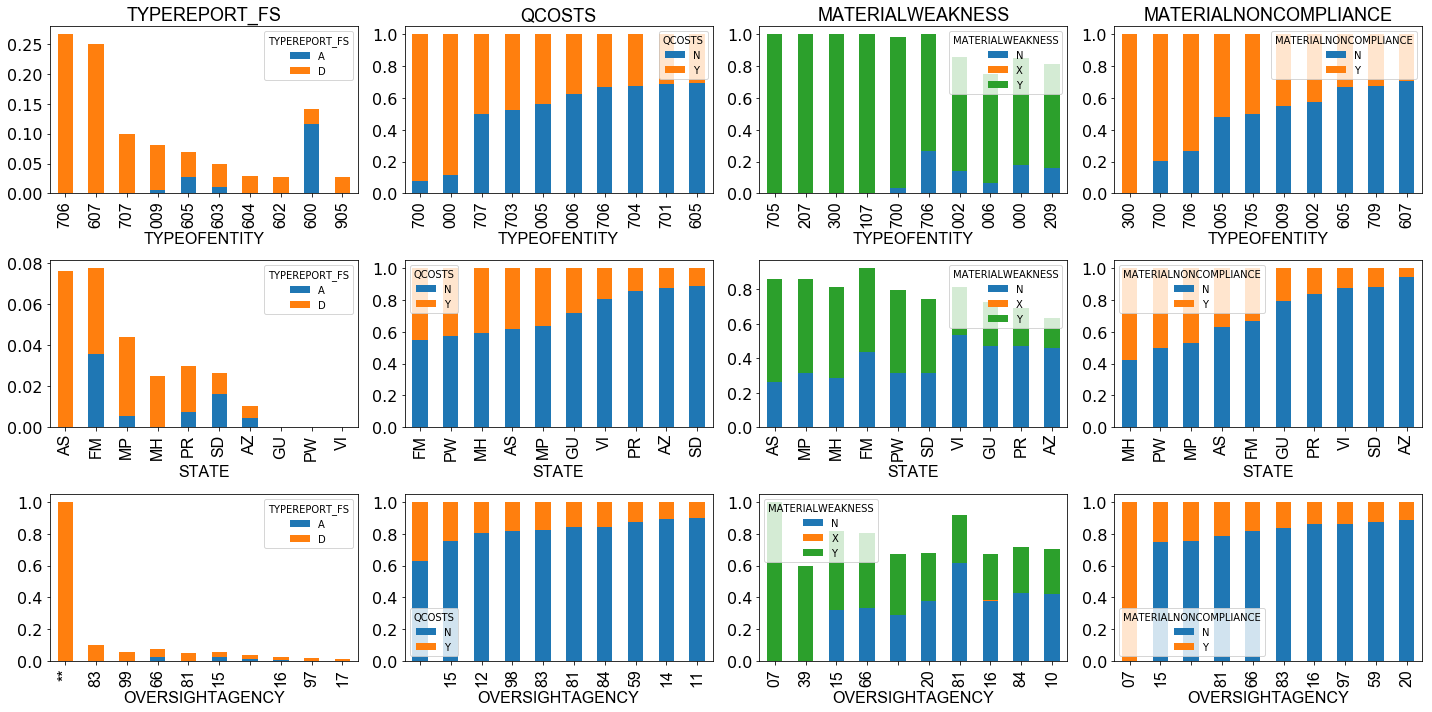

In [226]:
fig, axes = plt.subplots(nrows=len(sortbys), ncols=len(fields), figsize=(len(fields)*5, 10))
for (i, sortby) in enumerate(sortbys):
    for (j, field) in enumerate(fields):
        series_grouped = df_plot.groupby(sortby)[field].value_counts()
        df_grouped = series_grouped.unstack()
        df_grouped_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)
        if 'TYPEREPORT' in field:
            df_select_fields = df_grouped_normalized[
                [i for i in df_grouped_normalized.columns if i in ['A', 'D']]
            ]
            top_sortby = df_select_fields.sort_values(['D', 'A'], ascending=False).head(10).index
        else:
            df_select_fields = df_grouped_normalized[
                [i for i in df_grouped_normalized.columns if i in ['Y', 'N', 'X']]
            ]
            top_sortby = df_select_fields['Y'].sort_values(ascending=False).head(10).index
        df_select_sorted = df_select_fields.reindex(index=top_sortby)
        plot_top_sorted = df_select_sorted.plot(
            kind='bar', fontsize=16, stacked=True, ax=axes[i, j]
        )
        if i == 0:
            plot_top_sorted.set_title(field, fontsize=18, fontname='Arial')
        plot_top_sorted.set_xticklabels(labels=df_select_sorted.index, fontsize=16, fontname='Arial')
        plot_top_sorted.set_xlabel(sortby, fontsize=16, fontname='Arial')
plt.tight_layout()
plt.show()

In [216]:
# df_plot[df_plot['STATE']=='AZ']['TYPEOFENTITY'].value_counts()
# df_plot[(df_plot['STATE']=='AZ') & (df_plot['TYPEOFENTITY']=='505')]['AUDITEENAME']